## Imports Necessários

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import xgboost as xgb
from xgboost import XGBRegressor

pd.set_option('display.max_rows', None)


In [2]:
df = pd.read_csv('C:\\Users\\marce\\OneDrive\\Dokumenti\\GitHub\\psValcann\\Valcann-Ps\\data\\vendas_produto_alfa.csv')

In [3]:
df.head()

,data,vendas,dia_da_semana,em_promocao,feriado_nacional
0,2025-08-08 22:01:44.459032,139.0,sexta-feira,False,False
1,2025-07-04 22:01:44.459032,133.0,sexta-feira,True,True
2,2024-12-25 22:01:44.459032,579.0,quarta-feira,True,False
3,2025-04-14 22:01:44.459032,105.0,segunda-feira,False,False
4,2026-03-25 22:01:44.459032,60.0,quarta-feira,True,False


## Exploratory Data Analysis

In [4]:
df.shape

(1015, 5)

In [25]:
df.dtypes

data                datetime64[ns]
vendas                     float64
dia_da_semana               object
em_promocao                 object
feriado_nacional            object
dtype: object

In [48]:
df.isnull().sum()

data                0
vendas              0
dia_da_semana       0
em_promocao         0
feriado_nacional    0
dtype: int64

### NULL Values

In [17]:
# Data
df = df.loc[~df['data'].isna()]

In [24]:
df['data'] = pd.to_datetime(df['data'])

In [19]:
# Vendas
df['vendas'] = df['vendas'].fillna(
    df.groupby('dia_da_semana')['vendas'].transform('mean')
)

,data,vendas,dia_da_semana,em_promocao,feriado_nacional
8,2024-11-25 22:01:44.459032,NaN,segunda-feira,False,False
15,2025-12-23 22:01:44.459032,NaN,terca-feira,True,False
22,2023-10-05 22:01:44.459032,NaN,quinta-feira,True,False
23,2026-03-07 22:01:44.459032,NaN,sabado,False,False
25,2025-12-12 22:01:44.459032,NaN,sexta-feira,True,False
29,2023-10-15 22:01:44.459032,NaN,domingo,False,False
38,2025-06-01 22:01:44.459032,NaN,domingo,False,False
46,2024-01-19 22:01:44.459032,NaN,sexta-feira,False,False
64,2026-04-12 22:01:44.459032,NaN,domingo,True,False
72,2026-05-15 22:01:44.459032,NaN,sexta-feira,True,False


In [28]:
# Dia da Semana

dias_semana = {
    0: 'segunda-feira',
    1: 'terca-feira',
    2: 'quarta-feira',
    3: 'quinta-feira',
    4: 'sexta-feira',
    5: 'sabado',
    6: 'domingo'
}

def preencher_dia_da_semana(row):
    if pd.isna(row['dia_da_semana']):
        return dias_semana[row['data'].weekday()]
    else:
        return row['dia_da_semana']

# Aplicar no dataframe
df['dia_da_semana'] = df.apply(preencher_dia_da_semana, axis=1)


In [47]:
# Em Promoção
probs = df['em_promocao'].value_counts(normalize=True)

# Função para imputar nulos
def imputar_em_promocao(val):
    if pd.isna(val):
        return np.random.choice([True, False], p=[probs[True], probs[False]])
    else:
        return val

df['em_promocao'] = df['em_promocao'].apply(imputar_em_promocao)


### Transformation

In [54]:
# Vendas -> INT
df['vendas'] = df['vendas'].astype(int)

# Em Promocao -> False 0 | True 1
df['em_promocao'] = df['em_promocao'].astype(int)

# Feriado Nacional -> False 0 | True 1
df['feriado_nacional'] = df['feriado_nacional'].astype(int)

feriado_nacional
False    945
True      60
Name: count, dtype: int64

### Univariate Analysis

In [10]:
df['vendas'].describe()

count    1000.000000
mean      126.746000
std        44.256866
min        50.000000
25%        88.000000
50%       128.000000
75%       165.000000
max       200.000000
Name: vendas, dtype: float64

#### Histograma

<Axes: xlabel='vendas', ylabel='Count'>

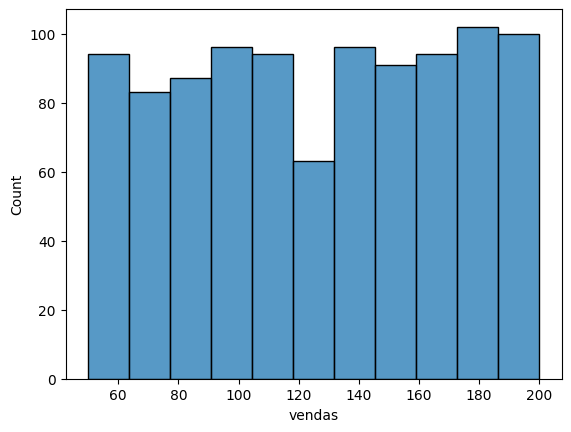

In [11]:
sns.histplot(data=df, x="vendas")

#### Boxplot

<Axes: xlabel='vendas'>

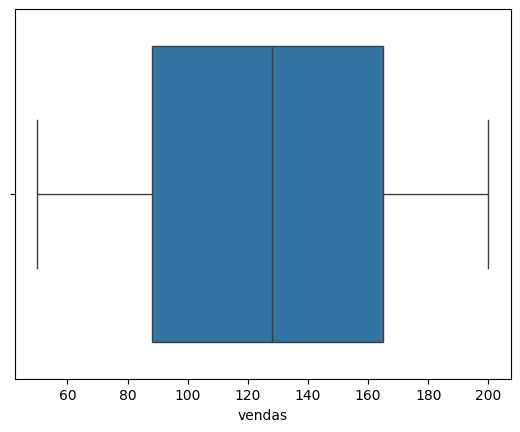

In [13]:
sns.boxplot(data=df, x="vendas")

## Pre Processing / Normalization

## Feature Engineering